# Examining the India-China region through climate reanalysis products ERA5 & NCEP, and climate prediction models RCP 2.6 & 8.5.

In this jupyter notebook, we compare global and regional values of mean 2m temperature, sea-surface temperature, surface pressure and total precipitation. On a regional scale, we chose the South and West region of Asia (India-China area; lon = 60:140, lat = 0:57) as this region is heavily influenced by the South Asian monsoon. We found a low pressure anomaly over Tibet, attributed to the Tibetan thermal low, and a prominent trend of low precipitation over Tibet, due to the rainshadow effect of the Himalayas.

The RCP 2.5 model indicated small changes from current trends, such as a rise in maximum temperature by ~1K. Running RCP 8.5 revealed the drastic rise in global minimum temperature by 27K, and intensification of temperatures, pressure and precipitation over the regional area. 

We then ran comparisons between the ERA5 and NCEP reanalysis data, and found that NCEP has a much lower resolution and thus precision versus ERA5.

# 1. Import all required libraries for model 

In [33]:
from mpl_toolkits.basemap import Basemap, shiftgrid, interp, addcyclic, cm
from netCDF4 import Dataset as netcdf 
from scipy import signal
import cdsapi
from pylab import *
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime 
import scipy.stats as stats
from netCDF4 import netcdftime
from netcdftime import utime
import matplotlib.dates as mdateschan
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import zipfile
import warnings
import pandas as pd
import statsmodels.api as sm
warnings.simplefilter('ignore')

# 2. Retrieve ERA5 reanalysis data
We chose a timespan of 40 years so as to paint a more accurate picture, without compromising too much on running time for the code. 

In [3]:
import cdsapi

c = cdsapi.Client()
 
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            '2m_temperature', 'sea_surface_temperature', 'surface_pressure', 'total_precipitation',
        ],
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        
        ],
        'time': '00:00',
        
    },
    'download.nc')


2020-03-05 09:35:58,309 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2020-03-05 09:35:58,510 INFO Request is completed
2020-03-05 09:35:58,511 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1583233984.8256254-6141-7-b89ff97a-537b-4538-8600-e230db875a51.nc to download.nc (3.8G)
2020-03-05 09:47:21,401 INFO Download rate 5.7M/s    


Result(content_length=4086525084,content_type=application/x-netcdf,location=http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1583233984.8256254-6141-7-b89ff97a-537b-4538-8600-e230db875a51.nc)

# 3. Mean and standard deviations

## 3.1.1 2m temperature mean and standard deviation on a global scale

Text(0.5, 1.0, 'Figure 1: 2m temperature between 1979-2019 globally [$K$] ')

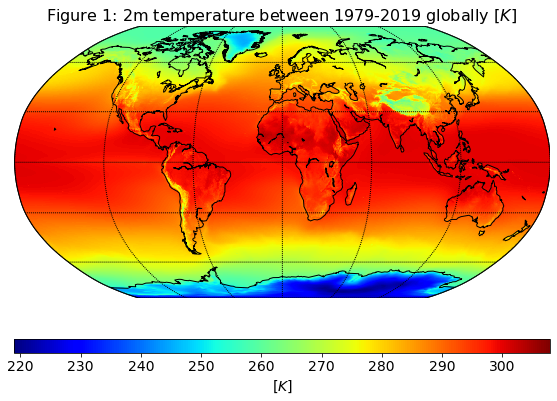

In [162]:
#Read data 
ncset = netcdf(r'download.nc')
ncset.set_auto_mask(False)
 
#Read variables
lon = ncset['longitude'][:]  
lat = ncset['latitude'][:] 
t = ncset['time'][:]    
u   = ncset['t2m'][0:480,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
u_10y = np.mean(u, axis=0) # calculate mean for all years and months
u_10y.shape
 
#Standard deviation 
u_10y_std=np.std(u, axis=0)
u_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(u_10y))
maxu = ceil(np.max(u_10y))
      
[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, u_10y, shading='flat',latlon=True, cmap='jet', vmin=minu, vmax=maxu)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 1: 2m temperature between 1979-2019 globally [$K$] ', fontsize = 16)

## 3.1.2 2m temperature mean and standard deviation on a regional scale

Text(0.5, 1.0, 'Figure 2: 2m temperature between 1979-2019 over India-China region [$K$]')

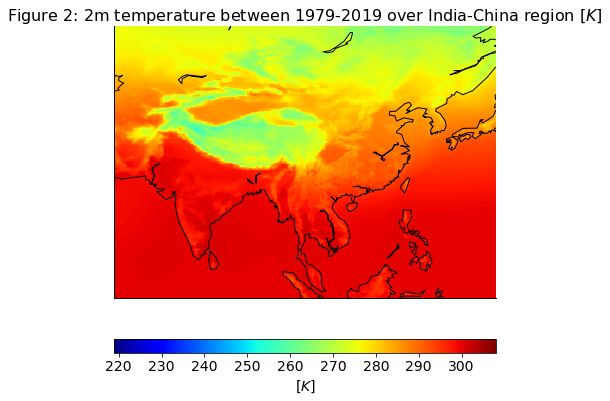

In [163]:
#Visualising mean and standard deviation on regional scale
plt.figure(2)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, u_10y, shading='flat',latlon=True, cmap='jet', vmin=minu, vmax=maxu)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 2: 2m temperature between 1979-2019 over India-China region [$K$]', fontsize = 16)

## 3.1.3 Zonal mean for 2m temperature

In [164]:
#Global Mean
u_10y = np.mean(u, axis=0) # calculate mean for all years and months
u_10y.shape
 
#Zonal mean 
u_10y_zm = np.mean(u_10y, axis=2)
u_10y_zm.shape
t_10 = t[0:2]
u_10y_zm_10 = u_10y_zm[0:2,:]
 
#Visualising zonal mean
minu = floor(np.min(u_10y_zm_10))
maxu = ceil(np.max(u_10y_zm_10))
[lats, t] = meshgrid(lat, t_10)
fig, ax = plt.subplots()
 
im = ax.pcolormesh(lats, t, u_10y_zm_10,  cmap='jet', vmin=minu, vmax=maxu)
cf = ax.contour(lats, t, u_10y_zm_10, 25, c='b',  vmin=minu, vmax=maxu)
 
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)
 
ax.set_title('Figure 3: Zonal mean of 2m temperature between 1979-2019 [K]', fontsize=16)
ax.set_xlabel('Latitude [^o]')
ax.set_ylabel('2m Temperature [^o]')
 
# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), t.min(), t.max()])
 
fig.colorbar(im)
fig.tight_layout()

IndexError: tuple index out of range

## 3.2.1 Sea-surface temperature mean and standard deviation on a global scale

Text(0.5, 1.0, 'Figure 4: Sea-surface temperature between 1979-2019 globally [$K$] ')

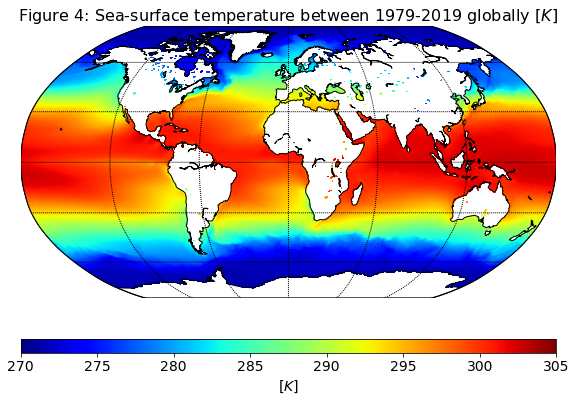

In [165]:
#Read data 
ncset = netcdf(r'download.nc')
ncset.set_auto_mask(True)
 
#Picking variables
lon = ncset['longitude'][:]  
lat = ncset['latitude'][:] 
t = ncset['time'][:]    
sst = ncset['sst'][0:480,:] #Choosing surface pressure as variable to analyse
 
#Global Mean
sst_10y = np.mean(sst, axis=0) # calculate mean for all years and months
sst_10y.shape
 
#Standard deviation 
sst_10y_std=np.std(sst, axis=0)
sst_10y.shape
 
#Visualising mean and standard deviation on global scale
minsst = floor(np.min(sst_10y))
maxsst = ceil(np.max(sst_10y))

[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='white')
h = m.pcolormesh(lons, lats, sst_10y, shading='flat',latlon=True, cmap='jet', vmin=minsst, vmax=maxsst)
m.colorbar(h, location='bottom', pad="15%", label='[K]') #Change unit for pressure
plt.title('Figure 4: Sea-surface temperature between 1979-2019 globally [K] ', fontsize = 16)

## 3.2.2 Sea-surface temperature mean and standard deviation on a regional scale

Text(0.5, 1.0, 'Figure 5: Sea-surface temperature between 1979-2019 over India China region [$K$]')

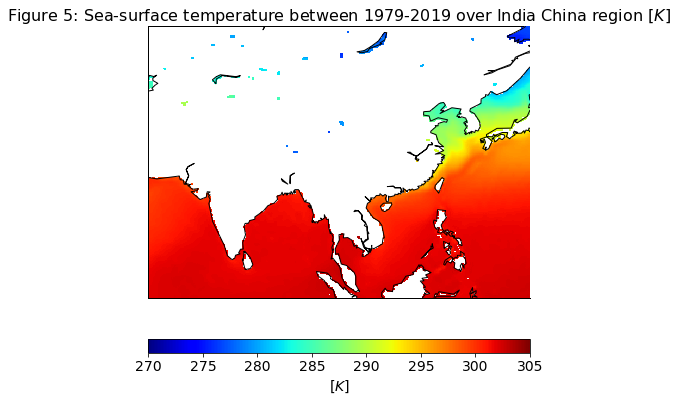

In [166]:
#Visualising mean and standard deviation on regional scale
plt.figure(2)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
#ncset.set_auto_mask(True)
h = m.pcolormesh(lons, lats, sst_10y, shading='flat',latlon=True, cmap='jet', vmin=minsst, vmax=maxsst)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 5: Sea-surface temperature between 1979-2019 over India China region [$K$]', fontsize = 16)

## 3.2.3 Zonal mean for sea-surface temperature

In [167]:
#Global Mean
sst_10y = np.mean(sst, axis=0) # calculate mean for all years and months
sst_10y.shape

#Zonal mean 
print(sst_10y.shape)
sst_10y_zm = np.mean(sst_10y, axis=2)
sst_10y_zm.shape
t_10 = t[0:2]
sst_10y_zm_10 = sst_10y_zm[0:2,:]

#Visualising zonal mean
figure(3)
minsst = floor(np.min(sst_10y_zm_10))
maxsst = ceil(np.max(sst_10y_zm_10))
[lats, t] = meshgrid(lat, t_10)
fig, ax = plt.subplots()
 
im = ax.pcolormesh(lats, t, sst_10y_zm_10,  cmap='jet', vmin=minsst, vmax=maxsst)
cf = ax.contour(lats, t, sst_10y_zm_10, 25, c='b',  vmin=minsst, vmax=maxsst)
 
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)
 
ax.set_title('Figure 6: Zonal mean of sea-surface temperature between 1979-2019 [K]', fontsize=16)
ax.set_xlabel('Latitude [^o]')
ax.set_ylabel('Sea surface temperature [K]')
 
# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), t.min(), t.max()])
fig.colorbar(im)
fig.tight_layout()


(721, 1440)


AxisError: axis 2 is out of bounds for array of dimension 2

## 3.3.1 Surface pressure mean and standard deviation on a global scale

Text(0.5, 1.0, 'Figure 7: Surface pressure between 1979-2019 globally [Pa] ')

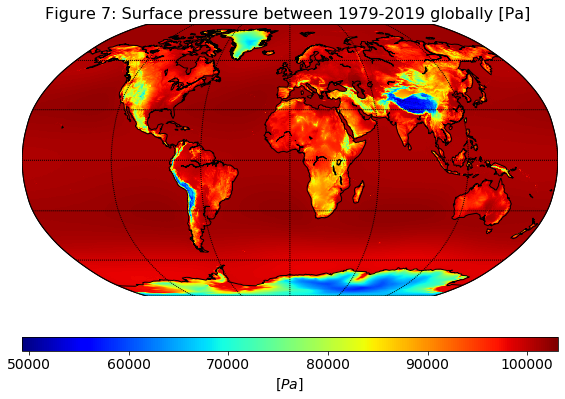

In [168]:
#Read data 
ncset = netcdf(r'download.nc')
ncset.set_auto_mask(False)
 
#Picking variables
lon = ncset['longitude'][:]  
lat = ncset['latitude'][:] 
t = ncset['time'][:]    
sp = ncset['sp'][0:480,:] #Choosing surface pressure as variable to analyse
 
#Global Mean
sp_10y = np.mean(sp, axis=0) # calculate mean for all years and months
sp_10y.shape
 
#Standard deviation 
sp_10y_std=np.std(sp, axis=0)
sp_10y.shape
 
#Visualising mean and standard deviation on global scale
minsp = floor(np.min(sp_10y))
maxsp = ceil(np.max(sp_10y))

[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, sp_10y, shading='flat',latlon=True, cmap='jet', vmin=minsp, vmax=maxsp)
m.colorbar(h, location='bottom', pad="15%", label='[$Pa$]') #Change unit for pressure
plt.title('Figure 7: Surface pressure between 1979-2019 globally [Pa] ', fontsize = 16)

## 3.3.2 Surface pressure mean and standard deviation on a regional scale

Text(0.5, 1.0, 'Figure 8: Surface pressure between 1979-2019 over India China region [Pa]')

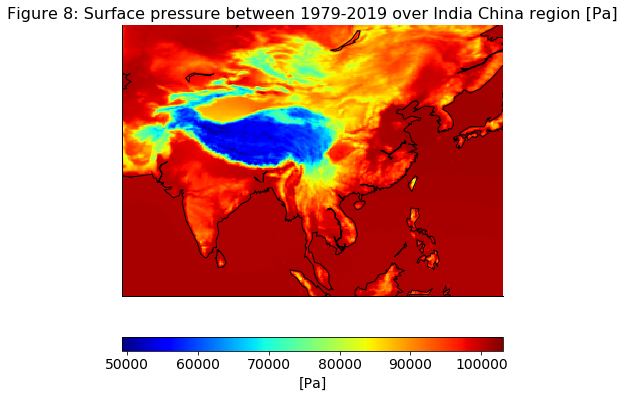

In [169]:
#Visualising mean and standard deviation on standard scale
plt.figure(2)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, sp_10y, shading='flat',latlon=True, cmap='jet', vmin=minsp, vmax=maxsp)
m.colorbar(h, location='bottom', pad="15%", label='[Pa]') #Change unit for pressure
plt.title('Figure 8: Surface pressure between 1979-2019 over India China region [Pa]', fontsize = 16)
 

## 3.3.3 Zonal mean for surface pressure

In [179]:
#Global Mean
sp_10y = np.mean(sp, axis=0) # calculate mean for all years and months
sp_10y.shape

#Zonal mean 
sp_10y_zm = np.mean(sp_10y, axis=2)
sp_10y_zm.shape
t_10 = t[0:2]
sp_10y_zm_10 = sp_10y_zm[0:2,:]

#Visualising zonal mean
figure(3)
minsp = floor(np.min(sp_10y_zm_10))
maxsp = ceil(np.max(sp_10y_zm_10))
[lats, t] = meshgrid(lat, t_10)
fig, ax = plt.subplots()
 
im = ax.pcolormesh(lats, t, sp_10y_zm_10,  cmap='jet', vmin=minsp, vmax=maxsp)
cf = ax.contour(lats, t, sp_10y_zm_10, 25, c='b',  vmin=minsp, vmax=maxsp)
 
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)
 
ax.set_title('Figure 9: Zonal mean of surface pressure between 1979-2019 [Pa]', fontsize=16)
ax.set_xlabel('Latitude [^o]') #Change unit for pressure
ax.set_ylabel('Surface pressure [Pa]') #Change unit for pressure
 
# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), t.min(), t.max()])
fig.colorbar(im)
fig.tight_layout()

IndexError: tuple index out of range

## 3.4.1 Total precipitation mean and standard deviation on a global scale 

Text(0.5, 1.0, 'Figure 10: Total precipitation for 1979-2019 globally [m]')

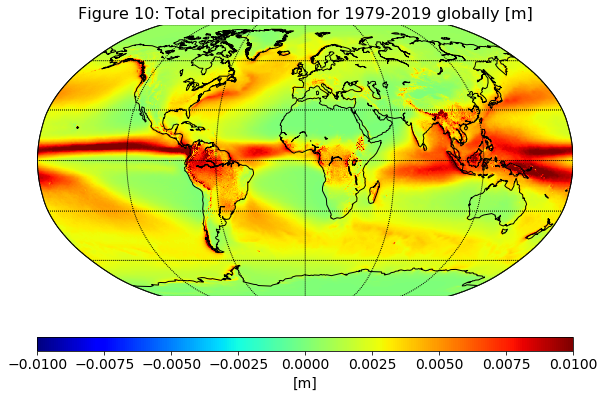

In [171]:
#Read data 
ncset = netcdf(r'download.nc')
ncset.set_auto_mask(False)
 
#Picking variables
lon = ncset['longitude'][:]  
lat = ncset['latitude'][:] 
t = ncset['time'][:]    
tp = ncset['tp'][0:492,:] #Choosing total precipitation as variable to analyse
 
#Global Mean
tp_10y = np.mean(tp, axis=0) # calculate mean for all years and months
tp_10y.shape
 
#Standard deviation 
tp_10y_std=np.std(tp, axis=0)
tp_10y.shape
 
#Visualising mean and standard deviation on global scale
mintp = floor(np.min(tp_10y))
maxtp = ceil(np.max(tp_10y))

[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, tp_10y, shading='flat',latlon=True, cmap='jet', vmin=-0.01, vmax=0.01)
m.colorbar(h, location='bottom', pad="15%", label='[m]')
plt.title('Figure 10: Total precipitation for 1979-2019 globally [m]', fontsize=16)

## 3.4.2 Total precipitation mean and standard deviation on a regional scale 

Text(0.5, 1.0, 'Figure 11: Total precipitation between 1979-2019 over India China region [$m$]')

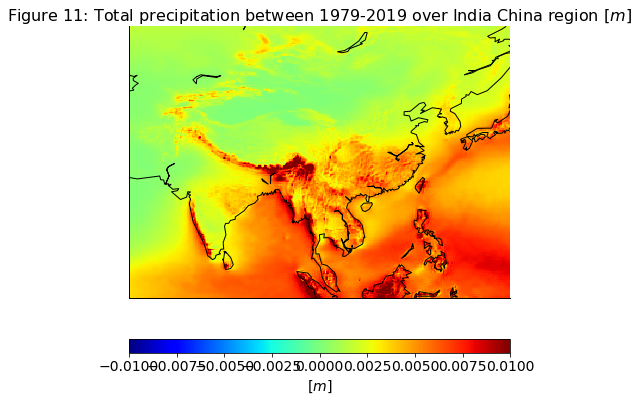

In [172]:
#Visualising mean and standard deviation on standard scale
plt.figure(2)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, tp_10y, shading='flat',latlon=True, cmap='jet', vmin=-0.01, vmax=0.01)
m.colorbar(h, location='bottom', pad="15%", label='[$m$]') #Change unit for pressure
plt.title('Figure 11: Total precipitation between 1979-2019 over India China region [$m$]', fontsize = 16)

## 3.4.3 Zonal mean for total precipitation

In [178]:
#Global Mean
tp_10y = np.mean(tp, axis=0) # calculate mean for all years and months
tp_10y.shape

#Zonal mean 
tp_10y_zm = np.mean(tp_10y, axis=2)
tp_10y_zm.shape
t_10 = t[0:2]
tp_10y_zm_10 = tp_10y_zm[0:2,:]

#Visualising zonal mean
figure(3)
mintp = floor(np.min(tp_10y_zm_10))
maxtp = ceil(np.max(tp_10y_zm_10))
[lats, t] = meshgrid(lat, t_10)
fig, ax = plt.subplots()
 
im = ax.pcolormesh(lats, t, tp_10y_zm_10,  cmap='jet', vmin=-0.01, vmax=0.01)
cf = ax.contour(lats, t, tp_10y_zm_10, 25, c='b',  vmin=-0.1, vmax=0.1)
 
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)
 
ax.set_title('Figure 12: Total precipitation between 1979-2019[m]', fontsize=16) #Change unit for pressure
ax.set_xlabel('Latitude [m]') #Change unit for pressure
ax.set_ylabel('Total precipitation [m]') #Change unit for pressure
 
# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), t.min(), t.max()])
fig.colorbar(im)
fig.tight_layout()

IndexError: tuple index out of range

## 3.5 Conclusion
Global 2m temperature and surface temperature are highest at low latitudes (near equator), and decrease polewards. The regional 2m temperature displays an anomalously cold area (~265-270K) in Tibet, southwest China. This is probably attributed to the Tibetan plateau and glaciers, and rainshadow effect from the Himalayas. India, on the other hand, has a mean 2m temperature of ~290K, and less temperature variation than global values.

Surface pressure is roughly even globally, except for huge anomalies of low surface pressure in the south pole, on Greenland (Icelandic Low) and along the west coast of both North and South American continents (thermal lows). Our chosen region exhibits the greatest anomaly over Tibet, due to the Tibetan thermal low (Trapasso L.M.,2005).

Total precipitation is concentrated along the equator, especially in South-east Asia. There is also somewhat high precipitation on the east coast of North America and East Asia, but near 0 at poles. On a regional scale, there is a prominent ridge of high precipitation within the continent, probably due to the orographic rainfall at the Himalayas.

# 4. Trends and significance
## 4.1 Visualising 2m temperature trends on a regional scale

In [39]:
rcParams['figure.figsize'] = 15, 6

#Reading the data 
ncset= netcdf(r'download.nc')
lons = ncset['longitude'][:]  
lats = ncset['latitude'][:]  
t2m  = ncset['t2m'][:]  
u   = ncset['t2m'][0:480,:,:]  
time = ncset['time'][:]
t_unit = ncset['time'].units

try :
    t_cal =ncset['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

nt, nlat, nlon = u.shape
ngrd = nlon*nlat

#Parse time 
utime = netcdftime.utime(t_unit, calendar = t_cal)

#Masking data
ncset.set_auto_mask(False)
 
#Linear trend calculation
u_grd  = u.reshape((nt, ngrd), order='F') 
x        = np.linspace(1,nt,nt) #.reshape((nt,1))
u_rate = np.empty((ngrd,1))
u_rate[:,:] = np.nan

for i in range(ngrd): 
    y = u_grd[:,i]   
    if(not np.ma.is_masked(y)):         
        z = np.polyfit(x, y, 1)
        u_rate[i,0] = z[0]*120.0

u_rate = u_rate.reshape((nlat,nlon), order='F')

Text(0.5, 1.0, 'Figure 13: 2m temperature changing Rate (K/decade)')

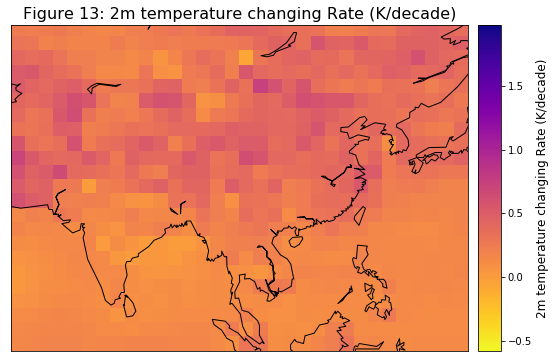

In [40]:
#Visualising trend 
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
 
x, y = m(*np.meshgrid(lons, lats))
u_10y = np.mean(u, axis=0) # calculate mean for all years and months
minu = np.min(u_10y)
maxu = np.max(u_10y)
clevs = np.linspace(minu, maxu, 20)
m.drawcoastlines()
cs = plt.contourf(x, y, u_rate.squeeze(), clevs, cmap=plt.cm.plasma)
cs = plt.pcolor(x[::10,::10], y[::10,::10], u_rate.squeeze()[::10,::10], cmap=plt.cm.plasma_r) 
cb = m.colorbar(cs)
cb.set_label('2m temperature changing Rate (K/decade)', fontsize=12)
plt.title('Figure 13: 2m temperature changing Rate (K/decade)', fontsize=16)

## 4.2 Visualise monthly 2m temperature anomaly time series

In [41]:
# Convert data into nyear x 12 x lat  x lon
u_grd_ym  = u.reshape((12,nt//12, ngrd), order='F').transpose((1,0,2))
u_grd_ym.shape

# Calculate seasonal cycle
u_grd_clm = np.mean(u_grd_ym, axis=0)
u_grd_clm.shape

# Remove seasonal cycle
u_grd_anom = (u_grd_ym - u_grd_clm).transpose((1,0,2)).reshape((nt, nlat, nlon), order='F')
u_grd_anom.shape

# Calculate area weights with cos(lats)
lonx, latx = np.meshgrid(lons, lats)
weights = np.cos(latx * np.pi // 180.)

# Calculate valid grids with total areas for global, north hemisphere, south hemisphere
u_glb_avg = np.zeros(nt)
u_nh_avg  = np.zeros(nt)
u_sh_avg  = np.zeros(nt)

for it in np.arange(nt):
    u_glb_avg[it] = np.ma.average(u_grd_anom[it, :], weights=weights)
    u_nh_avg[it]  = np.ma.average(u_grd_anom[it,0:nlat//2,:],    weights=weights[0:nlat//2,:])
    u_sh_avg[it]  = np.ma.average(u_grd_anom[it,nlat//2:nlat,:], weights=weights[nlat//2:nlat,:])

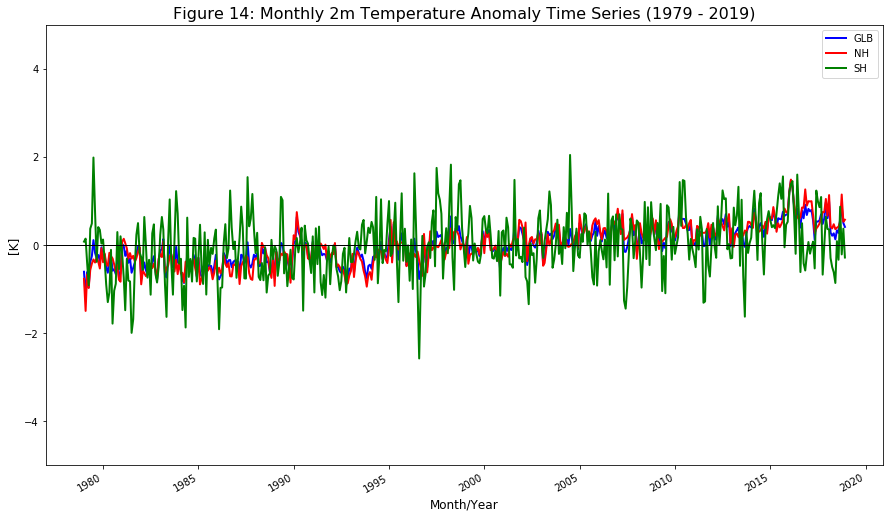

In [43]:
# Visualise
fig, ax = plt.subplots(1, 1 , figsize=(15,5))

datevar = utime.num2date(time)

ax.plot(datevar[0:480], u_glb_avg, color='b', linewidth=2, label='GLB')
ax.plot(datevar[0:480], u_nh_avg,  color='r', linewidth=2, label='NH')
ax.plot(datevar[0:480], u_sh_avg,  color='g', linewidth=2, label='SH')

ax.axhline(0, linewidth=1, color='k')
ax.legend()
ax.set_title('Figure 14: Monthly 2m Temperature Anomaly Time Series (1979 - 2019)', fontsize=16)
ax.set_xlabel('Month/Year', fontsize=12)
ax.set_ylabel('[K]', fontsize=12)
ax.set_ylim(-5, 5)
fig.set_figheight(9)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y')

## 4.3 Conclusion

From Fig 13, it is evident that there is a general increase in 2m temperature per decade of at least 0.5K. There is significant warming over the land, especially on the coast of Pakistan and south China (up to 1K). The 2m temperature rise over Pakistan may be attributed to anthropogenic climate change (Khan et al., 2019).

# 5. Monthly climatology

## 5.1 Sea surface temperature

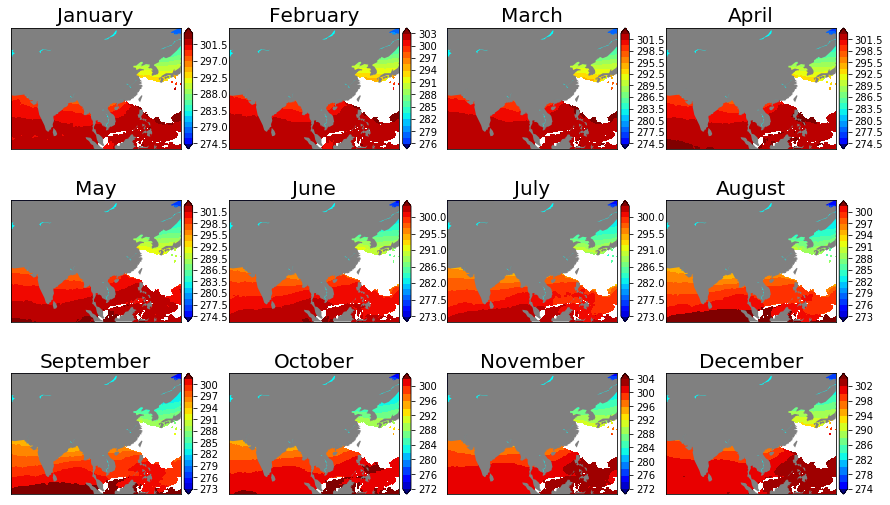

In [27]:
rcParams['figure.figsize'] = 15, 9
 
#Read data
ncset= netcdf(r'download.nc')
 
lons = ncset['longitude'][:]  # Get longitude
lats = ncset['latitude'][::-1]  # Reverse temperature and latitude so they go from south to north.
sst  = ncset['sst'][0:480,:,:]

 
#Transforming data
sst,lons  = shiftgrid(180.,sst,lons,start=False) #shift data so lons go from -180 to 180 instead of 0 to 360.
#sst,lons  = addcyclic(sst, lons)
lons,lats = np.meshgrid(lons, lats)
 
#Calculating monthly climatology
ntime,nrow,ncol = sst.shape
sstym  = sst.reshape((12, ntime//12, nrow, ncol),order='F') # convert (yearmonths|lat|lont) to (years|12months|lat|lon)
sstclm = sstym.mean(axis=1) # along the year axis
                   

#Plotting monthly climatology 
fig, axes = plt.subplots(3,4)
flat_axes = axes.reshape(-1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
 
# coordinates transformation
x, y = m(lons, lats)
 
# string month names
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
 
sst_10y = np.mean(sst, axis=0) # calculate mean for all years and months
minsst = np.min(sst_10y)
maxsst = np.max(sst_10y)
 
imon = -1
for ax in flat_axes:
    m.ax = ax
    imon = imon + 1 
    cssst = m.contourf(x,y, sstclm[imon], 20, vmin=minsst, cmap='jet', vmax=maxsst, extend='both') 
    m.colorbar(cssst,"right", size="5%", pad='2%') 
    plt.title( month_lst[imon], fontsize=20) 
    m.fillcontinents(color='gray', lake_color='aqua')

## 5.2 Surface pressure

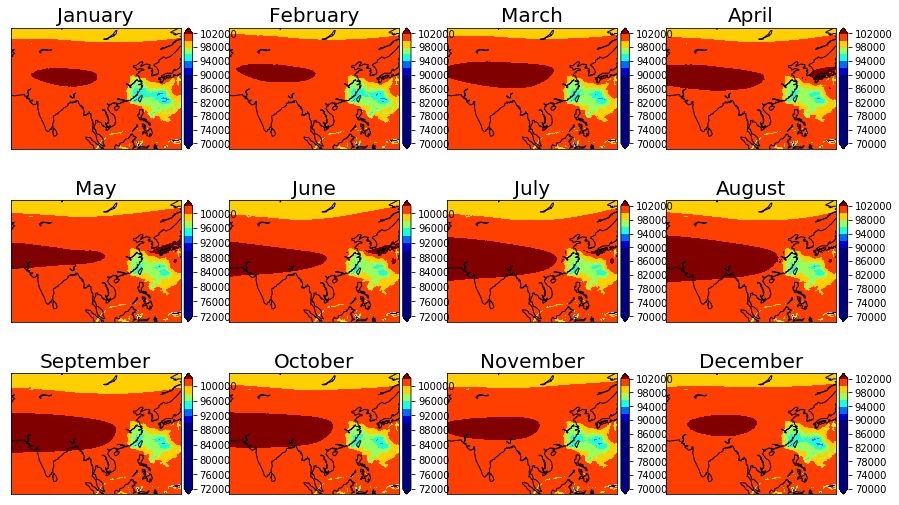

In [28]:
rcParams['figure.figsize'] = 15, 9
 
#Read data
ncset= netcdf(r'download.nc')
 
lons = ncset['longitude'][:]  # Get longitude
lats = ncset['latitude'][::-1]  # Reverse temperature and latitude so they go from south to north.
sp  = ncset['sp'][0:480,:,:]

#Transforming data
sp,lons  = shiftgrid(180.,sp,lons,start=False) #shift data so lons go from -180 to 180 instead of 0 to 360.
lons,lats = np.meshgrid(lons, lats)
 
#Calculating monthly climatology
ntime,nrow,ncol = sp.shape
spym  = sp.reshape((12, ntime//12, nrow, ncol),order='F') # convert (yearmonths|lat|lont) to (years|12months|lat|lon)
spclm = spym.mean(axis=1) # along the year axis
                   
#Plotting monthly climatology 
fig, axes = plt.subplots(3,4)
flat_axes = axes.reshape(-1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
 
# coordinates transformation
x, y = m(lons, lats)
 
# string month names
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
 
sp_10y = np.mean(sp, axis=0) # calculate mean for all years and months
minsp = 90000
maxsp = np.max(sp_10y)
 
imon = -1
for ax in flat_axes:
    m.ax = ax
    imon = imon + 1 
    cssp = m.contourf(x,y, spclm[imon], 20, vmin=minsp, cmap='jet', vmax=maxsp, extend='both') 
    m.colorbar(cssp,"right", size="5%", pad='2%') 
    plt.title( month_lst[imon], fontsize=20) 
    m.drawcoastlines()

## 5.3 Total precipitation

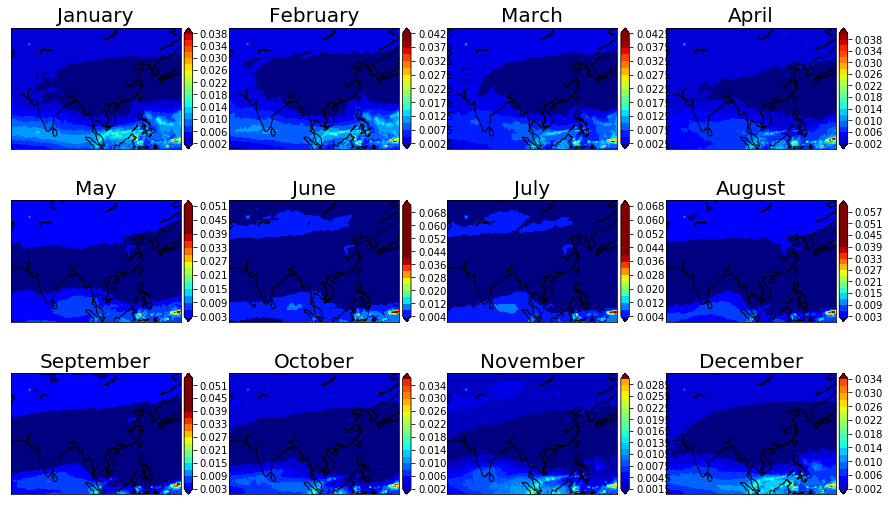

In [31]:
rcParams['figure.figsize'] = 15, 9

#Read data
ncset= netcdf(r'download.nc')
 
lons = ncset['longitude'][:]  # Get longitude
lats = ncset['latitude'][::-1]  # Reverse temperature and latitude so they go from south to north.
tp  = ncset['tp'][0:480,:,:]
 
#Transforming data
tp,lons  = shiftgrid(180.,tp,lons,start=False) #shift data so lons go from -180 to 180 instead of 0 to 360.
lons,lats = np.meshgrid(lons, lats)
 
#Calculating monthly climatology
ntime,nrow,ncol = tp.shape
tpym  = tp.reshape((12, ntime//12, nrow, ncol),order='F') # convert (yearmonths|lat|lont) to (years|12months|lat|lon)
tpclm = tpym.mean(axis=1) # along the year axis

#Plotting monthly climatology 
fig, axes = plt.subplots(3,4)
flat_axes = axes.reshape(-1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
 
# coordinates transformation
x, y = m(lons, lats)
 
# string month names
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
 
tp_10y = np.mean(tp, axis=0) # calculate mean for all years and months
mintp = np.min(tp_10y)
maxtp = 0.030

imon = -1
for ax in flat_axes:
    m.ax = ax
    imon = imon + 1 
    cstp = m.contourf(x,y, tpclm[imon], 20, vmin=mintp, cmap='jet', vmax=0.04, extend='both') 
    m.colorbar(cstp,"right", size="5%", pad='2%') 
    plt.title( month_lst[imon], fontsize=20) 
    m.drawcoastlines()

## 5.4 Conclusion

The India-China region has an Am climate (tropical monsoon), which is supported by the distinct wet summer season (June-October) and dry winter season.

There is higher surface pressure over the continent in June-October, which corresponds to the the pressure gradient force bringing moist air from the low pressure zone over the ocean and thus higher precipitation. This marks the wet monsoon season. 

During the dry winter season, cold, dry air from inland flows, due to a pressure gradient, southwest towards India.

# 6. Spectral Analysis
Spectral analysis stems from the concept that any wave signal can be expressed as a sum of sine waves of different frequencies. Thus it is useful for analysing multi-dimensional sequenced data (i.e. space and time), to identify how much of each frequency constitutes the signal.

In this sextion, we used the continuous wavelet spectrum for total precipitation.

Text(0.5, 0, 'Year')

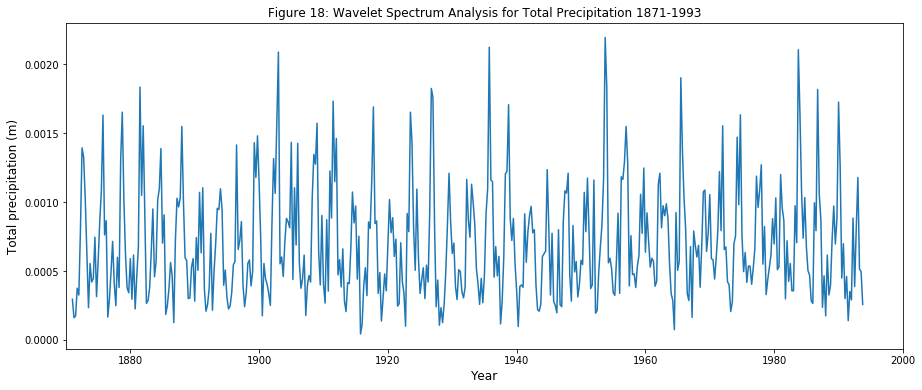

In [44]:
rcParams['figure.figsize'] = 15, 6
 
#Read data
ncset= netcdf(r'download.nc')
 
lons = ncset['longitude'][:]  # Get longitude
lats = ncset['latitude'][::-1]  # Reverse temperature and latitude so they go from south to north.
tp  = ncset['tp'][0:492,:,:]
tp.shape
n=len(tp)
dt = 0.25

time = np.arange(n)*dt + 1871.0   # construct time array
xlim = [1870,2000]  # plotting range

plt.plot(time,tp[:,0,0])
xrange=plt.xlim(xlim)
plt.title('Figure 18: Wavelet Spectrum Analysis for Total Precipitation 1871-1993', fontsize=12)
plt.ylabel('Total precipitation (m)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# 7. CO2 Levels
Atmospheric CO2 data was downloaded from the XCO2_EMMA and MERGED .zip file through CDSAPI. It covers the period from Jan-2003 to Jan-2016.. CO2 is expressed as column-average dry-air mole fraction micromol/mol, abbreviated as ppm.
This data was generated using existing Level 2 sensors, as well as an operational GOSAT XCO2 Level 2 product.

In [87]:
#retrieving data 
import cdsapi
 
c = cdsapi.Client()
 
c.retrieve(
    'satellite-carbon-dioxide',
    {
        'format': 'zip',
        'day': '01',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'year': [
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016',
        ],
        'version': '3.0',
        'sensor_and_algorithm': 'merged_emma',
        'variable': 'xco2',
        'processing_level': 'level_2',
    },
    'download1.zip')


2020-03-05 10:44:28,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-carbon-dioxide
2020-03-05 10:44:28,255 INFO Request is completed
2020-03-05 10:44:28,256 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/dataset-satellite-carbon-dioxide-67883350-4a8e-4ddb-9903-801e6a8433e8.zip to download1.zip (9.8M)
2020-03-05 10:44:30,100 INFO Download rate 5.3M/s   


Result(content_length=10226391,content_type=application/zip,location=http://136.156.133.36/cache-compute-0010/cache/data8/dataset-satellite-carbon-dioxide-67883350-4a8e-4ddb-9903-801e6a8433e8.zip)

In [88]:
#Unzip .zip file 
with zipfile.ZipFile('download1.zip','r') as zip_ref:
    zip_ref.extractall('co2')
    
#Add to path
import os
from pathlib import Path

p = Path(os.getcwd())
p.joinpath('/Users/Gillian/co2/')

PosixPath('/Users/Gillian/co2')

In [89]:
matplotlib.rc('figure', figsize = (12, 7)) # Plot size to 12" x 7"
matplotlib.rc('font', size = 14) # Font size to 14
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white') # Set backgound color to white

## 7.1 Global CO2 Levels

Text(0.5, 0, 'Seconds')

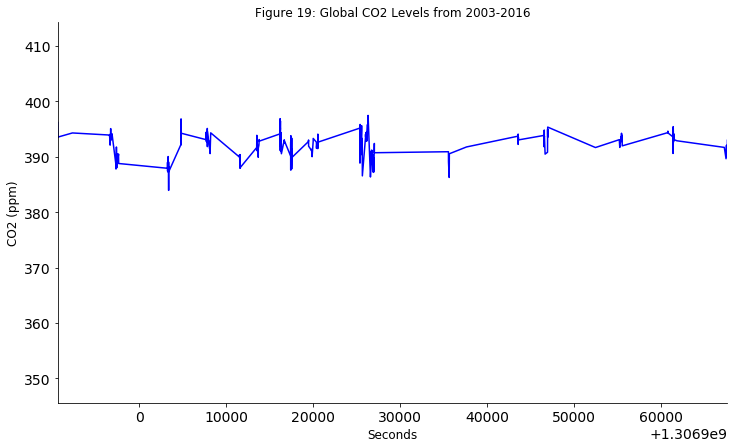

In [90]:
matplotlib.rc('figure', figsize = (12, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

os.chdir('co2')

co2_files = os.listdir()

xco2, time, lat, lon = [], [], [], []

for index, fname in enumerate(co2_files):
    if fname.endswith('.nc'):
        z = netcdf(fname)
        xco2 = z['xco2'][:]
        time = z['time'][:]
        lat = z['latitude'][:] 
        lon = z['longitude'][:]
        xlim = [min(time),max(time)]  # plotting range
        plt.plot(time,xco2,'b')
        xrange=plt.xlim(xlim)
os.chdir('..')

plt.title('Figure 19: Global CO2 Levels from 2003-2016', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xlabel('Seconds', fontsize=12)

# 8. Attempt a forecast using RCP 2.6 and 8.5
RCP2.6 shows the scenario in which greenhouse gas (GHG) concentration levels fall drastically from around 3.1Wm-2 to 2.6Wm-2 by 2099. This represents an idealised case of extreme GHG reduction.

RCP8.5, on the other hand, represents a "business as usual" scenario, where GHGs increase to 8.5Wm-2 by 2100. We chose to look at these two models as they present two extreme cases, and wanted to find out how such extreme scenarios can impact the monsoon cycle in the South and East Asia region.

## 8.1 RCP 2.6

In [40]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'projections-cmip5-monthly-single-levels',
    {
        'ensemble_member': 'r1i1p1',
        'format': 'zip',
        'experiment': 'rcp_2_6',
        'variable': [
            '2m_temperature','surface_pressure',
        ],
        'period': '200601-209912',
        'model': 'bcc_csm1_1',
    },
    'download.zip')

2020-03-05 07:09:03,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip5-monthly-single-levels
2020-03-05 07:09:05,212 INFO Request is completed
2020-03-05 07:09:05,214 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/dataset-projections-cmip5-monthly-single-levels-1628d411-50d9-40f0-ae26-ef6a9e8f7016.zip to download.zip (50.3M)
2020-03-05 07:09:12,979 INFO Download rate 6.5M/s   


Result(content_length=52742406,content_type=application/zip,location=http://136.156.132.235/cache-compute-0006/cache/data8/dataset-projections-cmip5-monthly-single-levels-1628d411-50d9-40f0-ae26-ef6a9e8f7016.zip)

In [41]:
#Unzip .zip file 
with zipfile.ZipFile('download.zip','r') as zip_ref:
    zip_ref.extractall('/Users/Gillian/Data')
    
#Add to path
import os
from pathlib import Path

p = Path(os.getcwd())
p.joinpath('/Users/Gillian/Data')

PosixPath('/Users/Gillian/Data')

Text(0.5, 1.0, 'Figure 20: RCP2.6 2m Temperature (2006-2099) over India-China region [$K$]')

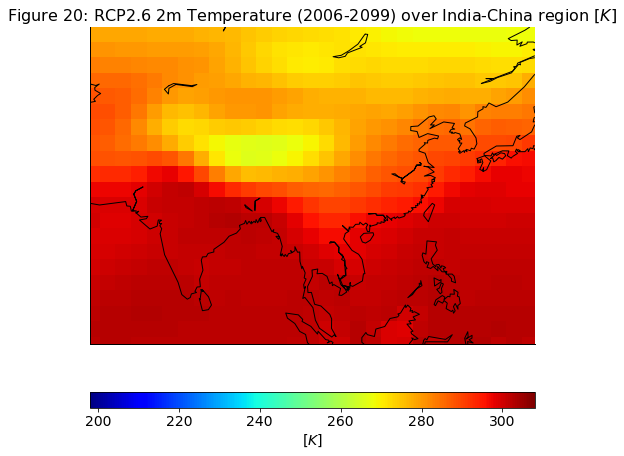

In [42]:
#Read data 
mod = netcdf(r'/Users/Gillian/Data/tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
tasmod = mod['tas'][0:1128,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
tasmod_10y = np.mean(tasmod, axis=0) # calculate mean for all years and months
tasmod_10y.shape

#Standard deviation 
tasmod_10y_std=np.std(tasmod, axis=0)
tasmod_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(tasmod_10y))
maxu = ceil(np.max(tasmod_10y))

[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, tasmod_10y, shading='flat',latlon=True, cmap='jet', vmin=198, vmax=308)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 20: RCP2.6 2m Temperature (2006-2099) over India-China region [$K$]', fontsize = 16)

Text(0.5, 1.0, 'Figure 21: RCP2.6 Surface pressure (2006-2099) over India-China region [$Pa$]')

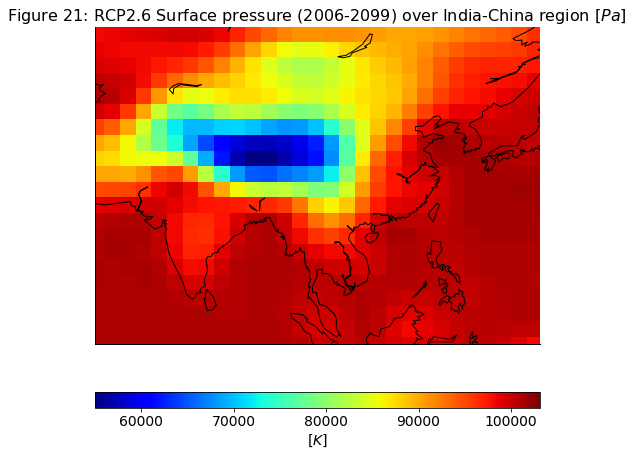

In [43]:
#Read data 
mod = netcdf(r'/Users/Gillian/Data/ps_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
psmod = mod['ps'][0:1128,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
psmod_10y = np.mean(psmod, axis=0) # calculate mean for all years and months
psmod_10y.shape

#Standard deviation 
psmod_10y_std=np.std(psmod, axis=0)
psmod_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(psmod_10y))
maxu = ceil(np.max(psmod_10y))
 
[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, psmod_10y, shading='flat',latlon=True, cmap='jet', vmin=minu, vmax=maxu)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 21: RCP2.6 Surface pressure (2006-2099) over India-China region [$Pa$]', fontsize = 16)

## 8.2 RCP 8.5

In [44]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'projections-cmip5-monthly-single-levels',
    {
        'ensemble_member': 'r1i1p1',
        'format': 'zip',
        'experiment': 'rcp_8_5',
        'variable': [
            '2m_temperature', 'surface_pressure',
        ],
        'period': '200601-210012',
        'model': 'access1_3',
    },
    'download.zip')

2020-03-05 07:09:26,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip5-monthly-single-levels
2020-03-05 07:09:27,031 INFO Request is completed
2020-03-05 07:09:27,033 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/dataset-projections-cmip5-monthly-single-levels-158ec8cd-bcab-4719-8d3b-45f4b5cd7db7.zip to download.zip (169.3M)
2020-03-05 07:09:44,817 INFO Download rate 9.5M/s  


Result(content_length=177534532,content_type=application/zip,location=http://136.156.133.39/cache-compute-0012/cache/data0/dataset-projections-cmip5-monthly-single-levels-158ec8cd-bcab-4719-8d3b-45f4b5cd7db7.zip)

In [45]:
#Unzip .zip file 
import zipfile
with zipfile.ZipFile('download.zip','r') as zip_ref:
    zip_ref.extractall('/Users/Gillian/Data1')
    
#Add to path
import os
from pathlib import Path

p = Path(os.getcwd())
p.joinpath('/Users/Gillian/Data1')

PosixPath('/Users/Gillian/Data1')

Text(0.5, 1.0, 'Figure 22: RCP8.5 2m Temperature (2006-2099) over India-China region [$K$]')

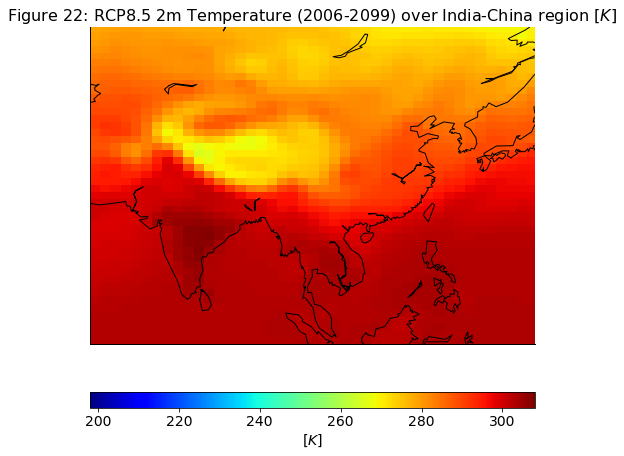

In [46]:
#Read data 
mod = netcdf(r'/Users/Gillian/Data1/tas_Amon_ACCESS1-3_rcp85_r1i1p1_200601-210012.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
tasmod = mod['tas'][0:1128,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
tasmod_10y = np.mean(tasmod, axis=0) # calculate mean for all years and months
tasmod_10y.shape

#Standard deviation 
tasmod_10y_std=np.std(tasmod, axis=0)
tasmod_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(tasmod_10y))
maxu = ceil(np.max(tasmod_10y))

[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, tasmod_10y, shading='flat',latlon=True, cmap='jet', vmin=198, vmax=308)
m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
plt.title('Figure 22: RCP8.5 2m Temperature (2006-2099) over India-China region [$K$]', fontsize = 16)

Text(0.5, 1.0, 'Figure 23: RCP8.5 Surface pressure (2006-2100) over India-China region [Pa]')

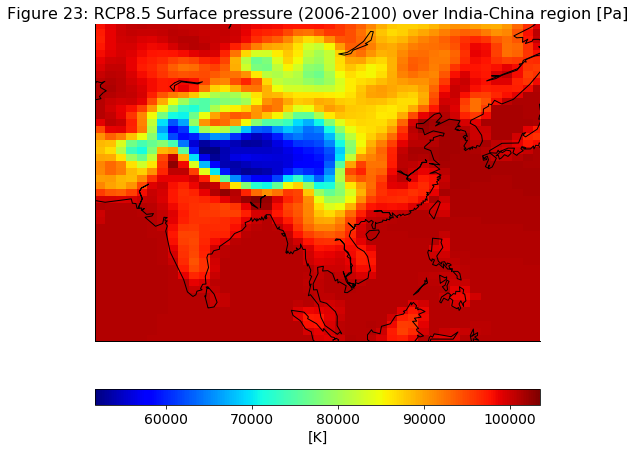

In [47]:
#Read data 
mod = netcdf(r'/Users/Gillian/Data1/ps_Amon_ACCESS1-3_rcp85_r1i1p1_200601-210012.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
psmod = mod['ps'][0:1140,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
psmod_10y = np.mean(psmod, axis=0) # calculate mean for all years and months
psmod_10y.shape

#Standard deviation 
psmod_10y_std=np.std(psmod, axis=0)
psmod_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(psmod_10y))
maxu = ceil(np.max(psmod_10y))
 
[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, psmod_10y, shading='flat',latlon=True, cmap='jet', vmin=minu, vmax=maxu)
m.colorbar(h, location='bottom', pad="15%", label='[K]')
plt.title('Figure 23: RCP8.5 Surface pressure (2006-2100) over India-China region [Pa]', fontsize = 16)

## 8.3 Conclusions

Overall, the RCP2.5 has a much lower resolution than RCP8.5, which makes a comparison between the two very rough.

### 2m temperature
Under RCP8.5 conditions,the global maximum and minimum 2m temperature increased by 27K and 1K respectively compared to ERA5 data. In this region, all areas increased temperature. In the RCP2.6 model, the temperature in the region has not changed significantly (given the low resolution of data), but the maximum temperature fell to 304K.  

The extreme rise in 2m temperature over the Tibetan plateau may be attributed to a phenomenon called elevation-dependent warming, though its mechanisms are not well understood presently (Liu & Yan, 2017).

### Surface pressure
In the RCP2.6 model, the low pressure area over Tibet is less pronounced. In RCP8.5, it is more pronounced. 

# 9. NCEP reanalysis data

## 9.1 2m temperature on a regional scale

Text(0.5, 1.0, 'Figure 24: 2m temperature between 1979-2019 globally [K] ')

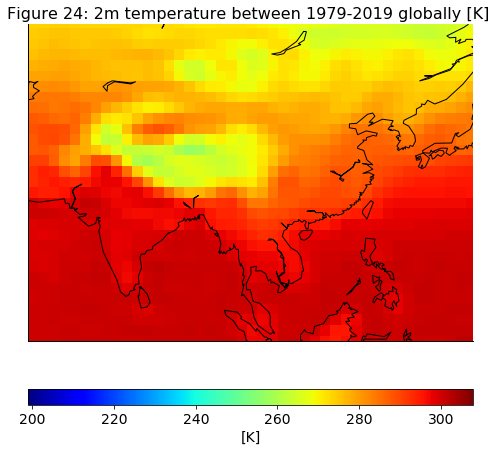

In [48]:
#Read data 
ncset = netcdf(r'air.2m.mon.ltm.nc')
ncset.set_auto_mask(False)
 
#Read variables
lon = ncset['lon'][:]  
lat = ncset['lat'][:] 
t = ncset['time'][:]    
u   = ncset['air'][:,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
u_10y = np.mean(u, axis=0) # calculate mean for all years and months
u_10y.shape

#Zonal mean 
u_10y_zm = np.mean(u_10y, axis=1)
u_10y_zm.shape
 
#Standard deviation 
u_10y_std=np.std(u, axis=0)
u_10y_std.shape

#Visualising mean and standard deviation on global scale
[lons, lats] = meshgrid(lon,lat)
 
plt.figure(1)
m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, u_10y, shading='flat',latlon=True, cmap='jet', vmin=199.0, vmax=308.0)
m.colorbar(h, location='bottom', pad="15%", label='[K]')
plt.title('Figure 24: 2m temperature between 1979-2019 globally [K] ', fontsize = 16)

## 9.2 Surface pressure on a regional scale

Text(0.5, 1.0, 'Figure 25: Surface Pressure between 1979-2019 globally [Pa] ')

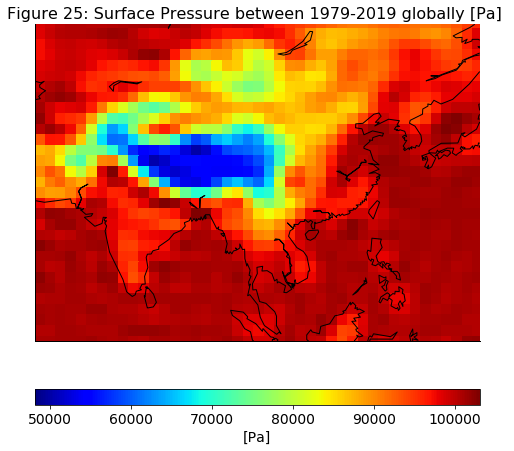

In [49]:
#Read data 
ncset = netcdf(r'pres.sfc.mon.ltm.nc')
ncset.set_auto_mask(False)
 
#Read variables
lon = ncset['lon'][:]  
lat = ncset['lat'][:] 
t = ncset['time'][:]    
p   = ncset['pres'][:,:] #Choosing surface pressure as variable to analyse
 
#Global Mean
p_10y = np.mean(p, axis=0) # calculate mean for all years and months
p_10y.shape
 
#Zonal mean 
p_10y_zm = np.mean(p_10y, axis=1)
p_10y_zm.shape
 
#Standard deviation 
p_10y_std=np.std(p, axis=0)
p_10y_std.shape

#Visualising mean and standard deviation on global scale
[lons, lats] = meshgrid(lon,lat)

m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, p_10y, shading='flat',latlon=True, cmap='jet', vmin=48103.0, vmax=103086.0)
m.colorbar(h, location='bottom', pad="15%", label='[Pa]')
plt.title('Figure 25: Surface Pressure between 1979-2019 globally [Pa] ', fontsize = 16)

## 9.3 Total precipitation rate on a regional scale

Text(0.5, 1.0, 'Figure 26: Total precipitation rate between 1979-2019 globally [m] ')

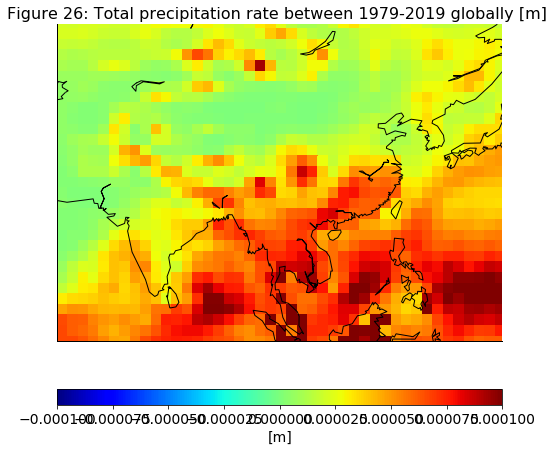

In [50]:
#Read data 
ncset = netcdf(r'prate.sfc.mon.ltm.nc')
ncset.set_auto_mask(False)
 
#Read variables
lon = ncset['lon'][:]  
lat = ncset['lat'][:] 
t = ncset['time'][:]    
tp   = ncset['prate'][:,:] #Choosing total precipitation rate as variable to analyse
 
#Global Mean
tp_10y = np.mean(tp, axis=0) # calculate mean for all years and months
tp_10y.shape
 
#Zonal mean 
tp_10y_zm = np.mean(tp_10y, axis=1)
tp_10y_zm.shape
 
#Standard deviation 
tp_10y_std=np.std(tp, axis=0)
tp_10y_std.shape

#Visualising mean and standard deviation on global scale
[lons, lats] = meshgrid(lon,lat)

m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
h = m.pcolormesh(lons, lats, tp_10y, shading='flat',latlon=True, cmap='jet', vmin=-0.0001, vmax=0.0001)
m.colorbar(h, location='bottom', pad="15%", label='[m]')
plt.title('Figure 26: Total precipitation rate between 1979-2019 globally [m] ', fontsize = 16)

## 9.4 Conclusion

The ERA5 and NCEP/NCAR reanalysis data reveal roughly similar information on 2m temperature, surface pressure and total precipitation.

However, the main difference between ERA5 and NCEP is that ERA5 is much more precise, thus giving much higher resolution data. ERA5 data has a resolution of 0.25° x 0.25° (latitude-longitude grid) (Smith, 2010). On the other hand, NCEP/NCAR is older, being continually updated since 1948, and has a resolution of 1.875° x 1.875°  (Kalnay et al., 1996), roughly 3x larger than ERA5. The difference in resolution is very noticeable on a regional scale, where the NCEP data resolution is very poor. 

As a result, NCEP/NCAR loads much faster than ERA5. This makes NCEP/NCAR more useful for making intiial observations of the climate, and ERA5 more useful on in-depth observations of climate trends on a regional level.

# 10. References

Trapasso L.M., (2005). Heat Low. In: Oliver J.E. (eds) Encyclopedia of World Climatology. Encyclopedia of Earth Sciences Series. Springer, Dordrecht

Khan, N., Shahid, S., Ismail, T.b. et al., (2019). Spatial distribution of unidirectional trends in temperature and temperature extremes in Pakistan. Theor Appl Climatol 136, 899–913.

Liu, X., Yan, L., (2017). Elevation-Dependent Climate Change in the Tibetan Plateau. DOI: 10.1093/acrefore/9780190228620.013.593

Smith, C., (2010). Overview of current atmospheric reanalyses. Retrieved from https://reanalyses.org/atmosphere/overview-current-atmospheric-reanalyses#NCEP1 on 3 March 2020.

Kalnay et al., (1996). The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470.
